In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, os, sys, re, pickle, math, copy
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from IPython.display import display, HTML

def showDF(df):
    display(df.head(4))
    display(df.dtypes)
    display(df.shape)

In [3]:
housing = fetch_california_housing()
housing = pd.DataFrame(housing.data, columns = housing.feature_names)
showDF(housing)

a = housing.as_matrix()[:, 0].reshape(-1, 1) # test reshape
print(a.shape)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)

(20640, 1)


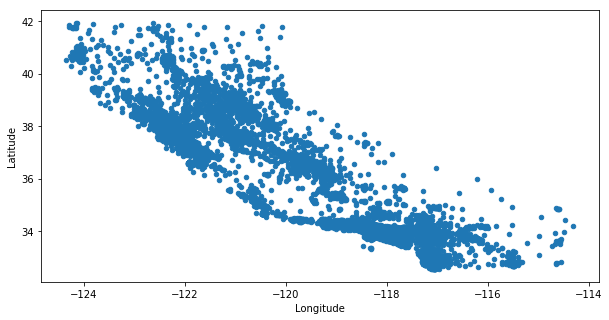

In [4]:
housing.plot(kind='scatter', x='Longitude', y='Latitude', figsize=(10, 5))

In [5]:
from scipy.stats import boxcox

a = housing.as_matrix()[:, 7].reshape(-1,1)
print(np.min(a), np.max(a))
a -= np.min(a) - 1e-5
print(a)
a1, lmbda = boxcox(a)
print("BoxCox-ed:")
print(a1)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler().fit(a1)
a2 = scaler.transform(a1)
print("Scaled:")
print(a2)

-124.35 -114.31
[[2.12001]
 [2.13001]
 [2.11001]
 ...
 [3.13001]
 [3.03001]
 [3.11001]]
BoxCox-ed:
[[1.13571041]
 [1.14596152]
 [1.12546088]
 ...
 [2.17809034]
 [2.07431971]
 [2.15732738]]
Scaled:
[[-1.32565921]
 [-1.32077927]
 [-1.3305384 ]
 ...
 [-0.82944471]
 [-0.87884367]
 [-0.83932871]]


In [70]:
# BoxCox + Standardized transformation
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class DataFrameCategoricalColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self;
    
    def transform(self, X, y=None):
        """
        return DataFrame
        """
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        numCols = list(X.select_dtypes(include=numerics).columns)
        X = X.drop(numCols, axis=1)
        return X

class DataFrameNumericColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self;
    
    def transform(self, X, y=None):
        """
        return DataFrame
        """
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        X = X.select_dtypes(include=numerics).copy()
        return X
    
class DataFrameToNArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self;
    
    def transform(self, X, y=None):
        return X.values

class DataFrameColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        return DataFrame
        """
        return X[self.columns]
    
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, debug=False):
        self.debug = debug
        self.lmbdas = []
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        out = None
        for i in range(X.shape[1]):
            if self.debug:
                print(type(self).__name__, ': working on column', i)
                
            col = X[:, i].reshape(-1, 1)
            col -= np.min(col) - 1e-5 # make sure all data are positive
            col, lmbda = boxcox(col)
            self.lmbdas.append(lmbda)
            
            if out is None:
                out = col
            else:
                out = np.c_[out, col]
        if self.debug:
            print(self.lmbdas)
            print("Done BoxCoxTransformer's transform")
        return out
    
class StandardizedBoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, debug=False):
        self.scaler = StandardScaler()
        self.debug = debug
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        out = None
        lmbdas = []
        for i in range(X.shape[1]):
            if self.debug:
                print(type(self).__name__, ': working on column', i)
                
            col = X[:, i].reshape(-1, 1)
            col -= np.min(col) - 1e-5 # make sure all data are positive
            col, lmbda = boxcox(col)
            lmbdas.append(lmbda)
            
            col = self.scaler.fit(col).transform(col)
            if out is None:
                out = col
            else:
                out = np.c_[out, col]
        if self.debug:
            print("Done StandardizedBoxCoxTransformer's transform")
        return out, lmbdas

BoxCoxTransformer : working on column 0
BoxCoxTransformer : working on column 1
BoxCoxTransformer : working on column 2
BoxCoxTransformer : working on column 3
BoxCoxTransformer : working on column 4
BoxCoxTransformer : working on column 5
BoxCoxTransformer : working on column 6
BoxCoxTransformer : working on column 7
[array([0.32505786]), array([0.80443763]), array([0.11079528]), array([0.02414263]), array([0.24502036]), array([0.03763226]), array([0.3983832]), array([1.03290346])]
Done BoxCoxTransformer's transform
[array([0.32505786]), array([0.80443763]), array([0.11079528]), array([0.02414263]), array([0.24502036]), array([0.03763226]), array([0.3983832]), array([1.03290346])]


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.928155,22.926250,2.009750,-0.368708,12.678842,0.629671,2.382452,1.135710
1,2.922212,12.595914,1.852446,-0.446124,23.393200,0.351227,2.375144,1.145962
2,2.648526,28.142958,2.247819,-0.299848,14.565328,0.757259,2.371483,1.125461
3,2.162422,28.142958,1.754957,-0.300368,15.114474,0.625482,2.371483,1.115213


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)

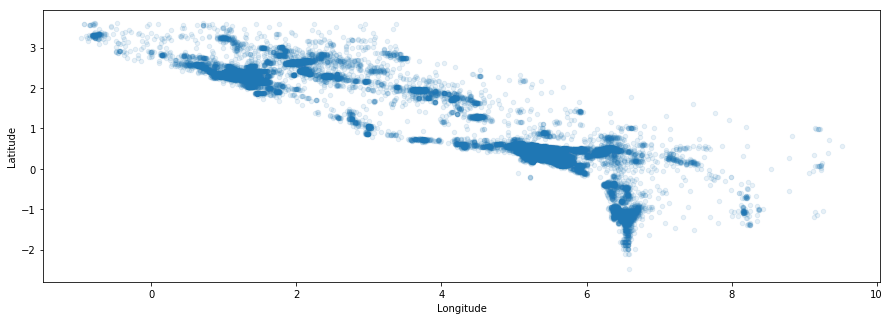

In [51]:
bc = BoxCoxTransformer(True)
a = bc.transform(housing.as_matrix())
x = pd.DataFrame(a, columns = housing.columns)
print(bc.lmbdas)
showDF(x)
x.plot(kind='scatter', x='Longitude', y='Latitude', figsize=(15, 5), alpha=0.1)

In [23]:
x1 = x.copy()
x1.iloc[0, 0] = None
showDF(x1)
display(x1.isnull().values.any()) # isnull: replace all cells with False/True, values: narray, any: any cell == True

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,NaN,22.926250,2.009750,-0.368708,12.678842,0.629671,2.382452,1.135710
1,2.922212,12.595914,1.852446,-0.446124,23.393200,0.351227,2.375144,1.145962
2,2.648526,28.142958,2.247819,-0.299848,14.565328,0.757259,2.371483,1.125461
3,2.162422,28.142958,1.754957,-0.300368,15.114474,0.625482,2.371483,1.115213


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)

True

In [63]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('dfarray', DataFrameToNArray()),
    ('boxcox', BoxCoxTransformer()),
    ('std_scaler', StandardScaler())
])
x2 = pipeline.fit_transform(housing)
lmbdas = pipeline.steps[1][1].lmbdas
showDF(pd.DataFrame(x2, columns=housing.columns))
print(lmbdas)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.973032,0.973907,1.050289,-0.274508,-1.611478,-0.350862,1.044085,-1.325659
1,1.965637,-0.562614,0.654056,-0.617175,1.089104,-1.092135,1.037835,-1.320779
2,1.625091,1.749833,1.649967,0.030290,-1.135984,-0.011196,1.034705,-1.330538
3,1.020234,1.749833,0.408488,0.027992,-0.997570,-0.362015,1.034705,-1.335417


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)

[array([0.32505786]), array([0.80443763]), array([0.11079528]), array([0.02414263]), array([0.24502036]), array([0.03763226]), array([0.3983832]), array([1.03290346])]


In [71]:
cols = ['Latitude', 'Longitude']
pipe2 = Pipeline([
    ("dfnumeric", DataFrameNumericColumns()), 
    ('dfcols', DataFrameColumnSelector(cols)), 
    ('dfarray', DataFrameToNArray())])
x2 = pipe2.fit_transform(housing)
showDF(pd.DataFrame(x2, columns=cols))
print('Original:')
showDF(housing)

,Latitude,Longitude
0,5.34001,2.12001
1,5.32001,2.13001
2,5.31001,2.11001
3,5.31001,2.10001


Latitude     float64
Longitude    float64
dtype: object

(20640, 2)

Original:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,7.82531,40.00001,6.137983,0.690486,319.00001,1.863258,5.34001,2.12001
1,7.80151,20.00001,5.391993,0.638557,2398.00001,1.417544,5.32001,2.13001
2,6.75751,51.00001,7.441992,0.740123,493.00001,2.109962,5.31001,2.11001
3,5.14321,51.00001,4.971208,0.739736,555.00001,1.855648,5.31001,2.10001


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)